## Motivation

Every two years, every member of the United States House of Representatives is up for election. After being elected, members of the House are given a set budget from the legislature itself to hire staff, buy office equipment, and defray other costs of legislating and addressing constituent concerns. While each office gets the same amount of money from Congress to spend on these purposes, congressional offices have discretion over how that allowance is actually spent, and we would like to see whether some spending patterns are associated with higher political success. 

# Getting/Formatting the Data

For this project, we decided to use the [House Office Expenditure Data](https://www.propublica.org/datastore/dataset/house-office-expenditures) from ProPublica as it contains well formatted data about house expenditures from 2009 to 2018. The main downside of this dataset is that it is missing data from the most recent midterm election, but we still have almost 10 years of data to work with.

To programatically access the datasets we are working with, we have included copies here [repository](https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/).

In [228]:
import pandas as pd
# just finna test with one of the files to see what happens
frames = []
# #manually add stuff for 2009 since only Q3 and Q4 are present
# frames.append(pd.read_csv('https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/2009Q3-house-disburse-detail.csv').dropna(subset = ['BIOGUIDE_ID']))
# frames.append(pd.read_csv('https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/2009Q4-house-disburse-detail.csv').dropna(subset = ['BIOGUIDE_ID']))


#automate the dataframes from 2010 to 2017
for i in range(2010, 2018):
    for j in range(1, 5):
        df = pd.read_csv('https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/' + str(i) + 'Q' + str(j) +'-house-disburse-detail.csv', thousands=',')
        df.dropna(subset = ['BIOGUIDE_ID'], inplace=True)
        df["QUARTER"] = str(i) + 'Q' + str(j)#df.apply(lambda row: str(i) + 'Q' + str(j))
        frames.append(df)
        

# manually add stuff for 2018 since only Q1 is present
df = pd.read_csv('https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/2018Q1-house-disburse-detail.csv', thousands=',')
df.dropna(subset = ['BIOGUIDE_ID'], inplace=True)
df["QUARTER"] = str(2018) + 'Q' + str(1)
frames.append(df)

house_data = pd.concat(frames)
house_data

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,BIOGUIDE_ID,OFFICE,QUARTER,CATEGORY,DATE,PAYEE,START DATE,END DATE,PURPOSE,AMOUNT,YEAR,TRANSCODE,TRANSCODELONG,RECORDID,RECIP (orig.),PROGRAM,SORT SEQUENCE
7597,A000014,HON. NEIL ABERCROMBIE,2010Q1,FRANKED MAIL,NaN,02­22 O4 NW201000101 UNITED STATES PO...,01/03/10,01/31/10,FRANKED MAIL,126.58,2010,NaN,NaN,NaN,02­22 O4 NW201000101 UNITED STATES PO...,NaN,NaN
7598,A000014,HON. NEIL ABERCROMBIE,2010Q1,FRANKED MAIL,NaN,03­25 O4 NW201000200 UNITED STATES PO...,02/01/10,02/28/10,FRANKED MAIL,1112.16,2010,NaN,NaN,NaN,03­25 O4 NW201000200 UNITED STATES PO...,NaN,NaN
7599,A000014,HON. NEIL ABERCROMBIE,2010Q1,PERSONNEL COMPENSATION,NaN,"ADAMS,LEE-ANN E",01/03/10,03/31/10,MILITARY LIAISON,21266.67,2010,NaN,NaN,NaN,"ADAMS,LEE-ANN E",NaN,NaN
7600,A000014,HON. NEIL ABERCROMBIE,2010Q1,PERSONNEL COMPENSATION,NaN,"ASSELBAYE, AMY",01/03/10,02/28/10,CHIEF OF STAFF,21750.00,2010,NaN,NaN,NaN,"ASSELBAYE, AMY",NaN,NaN
7601,A000014,HON. NEIL ABERCROMBIE,2010Q1,PERSONNEL COMPENSATION,NaN,"CHAN,GLORIA S",02/01/10,02/28/10,SHARED EMPLOYEE,4500.00,2010,NaN,NaN,NaN,"CHAN,GLORIA S",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61345,Z000017,2017 HON. LEE M. ZELDIN,2018Q1,SUPPLIES AND MATERIALS,2/19/18,CITI PCARD-READYREFRESH BY NESTLE,12/29/17,12/30/17,OFFICE SUPPLIES (OUTSIDE),54.85,2017,AP,NaN,974834,NaN,OFFICIAL EXPENSES OF MEMBERS,DETAIL
61346,Z000017,2017 HON. LEE M. ZELDIN,2018Q1,SUPPLIES AND MATERIALS,2/19/18,CITI PCARD-TIMES REVIEW NEWSPAP,12/29/17,1/26/18,PUBLICATIONS/REFERENCE MAT'L,110.00,2018,AP,NaN,974834,NaN,OFFICIAL EXPENSES OF MEMBERS,DETAIL
61347,Z000017,2017 HON. LEE M. ZELDIN,2018Q1,SUPPLIES AND MATERIALS,NaN,NaN,NaN,NaN,SUPPLIES AND MATERIALS TOTALS:,2183.20,2018,NaN,NaN,NaN,NaN,OFFICIAL EXPENSES OF MEMBERS,SUBTOTAL
61348,Z000017,2017 HON. LEE M. ZELDIN,2018Q1,SUPPLIES AND MATERIALS,NaN,NaN,NaN,NaN,OFFICIAL EXPENSES OF MEMBERS TOTALS:,38303.93,2018,NaN,NaN,NaN,NaN,OFFICIAL EXPENSES OF MEMBERS,SUBTOTAL


[election data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IG0UN2)

In [229]:
election_data = pd.read_csv('https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/1976-2020-house.csv')

# filter out the years before 2009 and after 2018
election_data = election_data[election_data['year'] >= 2009]
election_data = election_data[election_data['year'] <= 2018]

election_data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version,fusion_ticket
22553,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,DAVID WALTER,CONSTITUTION,False,TOTAL,26357,156281,False,20220331,False
22554,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,JO BONNER,REPUBLICAN,False,TOTAL,129063,156281,False,20220331,False
22555,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,False,WRITEIN,NaN,True,TOTAL,861,156281,False,20220331,False
22556,2010,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,NaN,False,BOBBY BRIGHT,DEMOCRAT,False,TOTAL,106865,219028,False,20220331,False
22557,2010,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,NaN,False,MARTHA ROBY,REPUBLICAN,False,TOTAL,111645,219028,False,20220331,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29631,2018,WYOMING,WY,56,83,68,US HOUSE,0,GEN,NaN,False,DANIEL CLYDE CUMMINGS,CONSTITUTION,False,TOTAL,6070,201245,False,20220331,False
29632,2018,WYOMING,WY,56,83,68,US HOUSE,0,GEN,NaN,False,GREG HUNTER,DEMOCRAT,False,TOTAL,59903,201245,False,20220331,False
29633,2018,WYOMING,WY,56,83,68,US HOUSE,0,GEN,NaN,False,LIZ CHENEY,REPUBLICAN,False,TOTAL,127963,201245,False,20220331,False
29634,2018,WYOMING,WY,56,83,68,US HOUSE,0,GEN,NaN,False,RICHARD BRUBAKER,LIBERTARIAN,False,TOTAL,6918,201245,False,20220331,False


Try to figure out what categories we are working with and how these categories should be group into broader categories

In [230]:
from collections import defaultdict
categories = defaultdict(lambda: 0)
def add_set(row):
      categories[row['CATEGORY']] += 1

#apply add_set to the house_data
house_data.apply(add_set, axis = 1)
categories

defaultdict(<function __main__.<lambda>()>,
            {'FRANKED MAIL': 83068,
             'PERSONNEL COMPENSATION': 359740,
             'TRAVEL': 617480,
             'RENT, COMMUNICATION, UTILITIES': 598709,
             'PRINTING AND REPRODUCTION': 121080,
             'OTHER SERVICES': 148187,
             'SUPPLIES AND MATERIALS': 514271,
             'EQUIPMENT': 84036,
             'PERSONNEL BENEFITS': 119,
             'TRANSPORTATION OF THINGS': 389,
             'RENT COMMUNICATION UTILITIES': 18459,
             'RENT  COMMUNICATION  UTILITIES': 92169,
             'BENEFITS TO FORMER PERSONNEL': 5})

In [231]:
replace = {
    'RENT  COMMUNICATION  UTILITIES': 'RENT, COMMUNICATION, UTILITIES',
    'RENT COMMUNICATION UTILITIES': 'RENT, COMMUNICATION, UTILITIES'
}
house_data.replace(to_replace=replace, value=None, inplace=True)

In [232]:
categories = defaultdict(lambda: 0)
def add_set(row):
      categories[row['CATEGORY']] += 1
      
house_data.apply(add_set, axis = 1)
str(categories)

"defaultdict(<function <lambda> at 0x7f8e94c10790>, {'FRANKED MAIL': 83068, 'PERSONNEL COMPENSATION': 359740, 'TRAVEL': 617480, 'RENT, COMMUNICATION, UTILITIES': 709337, 'PRINTING AND REPRODUCTION': 121080, 'OTHER SERVICES': 148187, 'SUPPLIES AND MATERIALS': 514271, 'EQUIPMENT': 84036, 'PERSONNEL BENEFITS': 119, 'TRANSPORTATION OF THINGS': 389, 'BENEFITS TO FORMER PERSONNEL': 5})"

In [233]:
import requests
from bs4 import BeautifulSoup
raw = requests.get("https://www.congress.gov/help/field-values/member-bioguide-ids")
soup = BeautifulSoup(raw.text, 'lxml')
table = soup.find('table')

# Since the entire thing is a formatted table, read it directly into a pandas dataframe
tabledf = pd.read_html(str(table))
tabledf = tabledf[0]
tabledf.dropna(subset = ['Member'], inplace=True)
tabledf.reset_index(drop=True, inplace=True)
members = tabledf['Member'].str.extractall("(.*), (.*) \((.*) - (.*)\)")

members.reset_index(drop=True, inplace=True)
members.rename(columns={0 : 'LASTNAME', 1: "FIRSTNAME", 2: "PARTY", 3: "STATE"}, inplace=True)
members['BIOGUIDE_ID'] = tabledf['Member ID']
members

,LASTNAME,FIRSTNAME,PARTY,STATE,BIOGUIDE_ID
0,Abdnor,James,Republican,South Dakota,A000009
1,Abercrombie,Neil,Democratic,Hawaii,A000014
2,Abourezk,James,Democratic,South Dakota,A000017
3,Abraham,Ralph Lee,Republican,Louisiana,A000374
4,Abraham,Spencer,Republican,Michigan,A000355
...,...,...,...,...,...
2422,Zinke,Ryan K.,Republican,Montana,Z000018
2423,Zion,Roger H.,Republican,Indiana,Z000010
2424,Zorinsky,Edward,Democratic,Nebraska,Z000013
2425,Zschau,Edwin V. W.,Republican,California,Z000014


Here we are importing data on the number of terms each congress member has served, we are being carfull to not count terms served after the period we are analysing.

In [234]:
import datetime

term_data = []
column_names = ['BIOGUIDE_ID','TERMS']

for url in ['https://theunitedstates.io/congress-legislators/legislators-current.json','https://theunitedstates.io/congress-legislators/legislators-historical.json']:
    r = requests.get(url)
    json_data = r.json()

    for json_el in json_data:
        number_of_terms = 0
        for term in json_el['terms']:
            start_date = datetime.datetime.strptime(term['start'], '%Y-%m-%d')
            # Make sure we are not looking at terms served after the period we are analysing
            if start_date.year < 2018:
                number_of_terms += 1
        term_data.append([json_el['id']['bioguide'], len(json_el['terms'])])

us_io_data = pd.DataFrame(term_data, columns=column_names)
us_io_data

,BIOGUIDE_ID,TERMS
0,B000944,10
1,C000127,5
2,C000141,13
3,C000174,9
4,C001070,3
...,...,...
12585,N000181,10
12586,H001088,2
12587,Y000033,25
12588,F000449,9


## k-means

In [235]:
import numpy as np
quarters = house_data['QUARTER'].unique()
categories = house_data['CATEGORY'].unique()

quarter = quarters[4]
hd_by_quarter = house_data[house_data['QUARTER'] == quarter]
bio_ids = hd_by_quarter['BIOGUIDE_ID'].unique()


spending_per_candidate = hd_by_quarter.groupby(['BIOGUIDE_ID','CATEGORY'])['AMOUNT'].sum()
spending_data = []
for bio_id in bio_ids:
    row = [bio_id]
    for category in categories:
        if category in spending_per_candidate[bio_id]:
            row.append(spending_per_candidate[bio_id][category])
        else:
            row.append(0)
    spending_data.append(row)
quarter_spending_df = pd.DataFrame(spending_data,columns = ["BIOGUIDE_ID"] + categories.tolist())
# quarter_spending_df = quarter_spending_df.dropna(axis='columns')
# quarter_spending_df.dropna(subset = ['BIOGUIDE_ID']))
quarter_spending_df
# spending_per_candidate.to_csv('spending_per_candidate_' + quarter + '.csv')

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL
0,A000014,0.00,-16.67,0.00,0.00,0.00,0.00,0.00,0.00,0,0.0,0
1,A000022,1909.79,221917.86,4408.29,42452.47,3351.43,14544.05,16893.16,29771.60,0,0.0,0
2,A000366,544.03,153141.65,5278.86,11755.74,3088.08,16290.80,3718.37,1154.26,0,0.0,0
3,A000055,1596.30,241025.00,10240.27,20557.94,2207.96,31803.95,10611.37,466.50,0,0.0,0
4,A000364,-1025.59,63958.87,2752.45,1535.46,0.00,75.00,118.85,2500.00,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
535,Y000062,1516.09,251042.50,16880.90,19938.93,3095.85,9820.06,16012.77,1585.11,0,0.0,0
536,Y000063,915.11,138985.01,9307.80,11831.87,2140.50,9601.80,17129.45,1925.10,0,0.0,0
537,Y000031,9060.30,225343.06,13973.82,22532.63,2197.04,13195.70,21175.40,8000.64,0,0.0,0
538,Y000033,1291.25,254234.48,14910.34,53791.82,2991.34,36233.64,27649.41,12792.63,0,0.0,0


In [236]:
# Left join the spending data with the candidate data
spending_member_info = quarter_spending_df.merge(members, on="BIOGUIDE_ID")
spending_member_info = spending_member_info.merge(us_io_data, on="BIOGUIDE_ID")
spending_member_info

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE,TERMS
0,A000014,0.00,-16.67,0.00,0.00,0.00,0.00,0.00,0.00,0,0.0,0,Abercrombie,Neil,Democratic,Hawaii,11
1,A000022,1909.79,221917.86,4408.29,42452.47,3351.43,14544.05,16893.16,29771.60,0,0.0,0,Ackerman,Gary L.,Democratic,New York,15
2,A000366,544.03,153141.65,5278.86,11755.74,3088.08,16290.80,3718.37,1154.26,0,0.0,0,Adams,Sandy,Republican,Florida,1
3,A000055,1596.30,241025.00,10240.27,20557.94,2207.96,31803.95,10611.37,466.50,0,0.0,0,Aderholt,Robert B.,Republican,Alabama,13
4,A000364,-1025.59,63958.87,2752.45,1535.46,0.00,75.00,118.85,2500.00,0,0.0,0,Adler,John H.,Democratic,New Jersey,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Y000062,1516.09,251042.50,16880.90,19938.93,3095.85,9820.06,16012.77,1585.11,0,0.0,0,Yarmuth,John A.,Democratic,Kentucky,8
536,Y000063,915.11,138985.01,9307.80,11831.87,2140.50,9601.80,17129.45,1925.10,0,0.0,0,Yoder,Kevin,Republican,Kansas,4
537,Y000031,9060.30,225343.06,13973.82,22532.63,2197.04,13195.70,21175.40,8000.64,0,0.0,0,Young,C. W. Bill,Republican,Florida,22
538,Y000033,1291.25,254234.48,14910.34,53791.82,2991.34,36233.64,27649.41,12792.63,0,0.0,0,Young,Don,Republican,Alaska,25


In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# train, test = train_test_split(spending_member_info[categories], test_size=0.2)
kmeans_model = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
kmeans_trained = kmeans_model.fit(spending_member_info[categories])
# kmeans_trained.cluster_centers_

clusters = kmeans_trained.predict(spending_member_info[categories])
for i in list(set(clusters)):
# i=0
    print("Cluster:",i)
    print(spending_member_info[["STATE","BIOGUIDE_ID","LASTNAME","TERMS"]][clusters==i].to_string())
    print("")
# print(spending_member_info[["PARTY","STATE"]][clusters==i].groupby("STATE").count())

In [238]:
print(spending_member_info[["PARTY","LASTNAME","STATE"]][clusters==6].to_string())

          PARTY LASTNAME    STATE
421  Republican   Rogers  Alabama


In [239]:
len(spending_member_info[["PARTY","LASTNAME"]][clusters==1])

92

## K-NN

In [240]:
import numpy as np
quarters = house_data['QUARTER'].unique()
categories = house_data['CATEGORY'].unique()
spending_data = []

for quarter in quarters:
    hd_by_quarter = house_data[house_data['QUARTER'] == quarter]
    bio_ids = hd_by_quarter['BIOGUIDE_ID'].unique()


    spending_per_candidate = hd_by_quarter.groupby(['BIOGUIDE_ID','CATEGORY'])['AMOUNT'].sum()
    for bio_id in bio_ids:
        row = [bio_id]
        for category in categories:
            if category in spending_per_candidate[bio_id]:
                row.append(spending_per_candidate[bio_id][category])
            else:
                row.append(0)
        spending_data.append(row)
quarter_spending_df = pd.DataFrame(spending_data,columns = ["BIOGUIDE_ID"] + categories.tolist())
# quarter_spending_df = quarter_spending_df.dropna(axis='columns')
# quarter_spending_df.dropna(subset = ['BIOGUIDE_ID']))
quarter_spending_df
# spending_per_candidate.to_csv('spending_per_candidate_' + quarter + '.csv')

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL
0,A000014,1498.61,259540.31,10891.59,21084.39,43.90,8348.02,4661.75,981.30,0.0,0.00,0.0
1,A000022,21011.90,242972.84,3655.22,33422.01,9794.18,21341.00,17776.34,2033.33,0.0,0.00,0.0
2,A000055,1671.92,264937.16,10360.45,19145.14,2130.92,11644.95,8005.85,601.50,0.0,0.00,0.0
3,A000364,85906.29,199660.40,7925.65,27119.41,75410.20,30479.70,6095.27,3894.33,0.0,0.00,0.0
4,A000358,40746.81,259704.20,6721.87,24703.34,45627.10,12367.41,6997.48,3610.12,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15271,Y000063,55204.06,423123.38,17043.38,50610.24,56150.28,15838.00,7338.90,638473.04,0.0,0.00,0.0
15272,Y000065,42615.44,440839.68,18841.70,76833.12,15479.96,59934.80,32815.94,739455.32,0.0,0.00,0.0
15273,Y000066,5573.22,450545.62,35434.88,62725.32,16377.48,21846.00,47897.86,652845.22,0.0,0.00,0.0
15274,Y000033,108.64,501229.40,32982.52,49944.42,993.70,29500.00,24403.84,649357.48,0.0,0.00,0.0


In [241]:
# Left join the spending data with the candidate data
spending_member_info = quarter_spending_df.merge(members, on="BIOGUIDE_ID")
spending_member_info = spending_member_info.merge(us_io_data, on="BIOGUIDE_ID")
spending_member_info

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE,TERMS
0,A000014,1498.61,259540.31,10891.59,21084.39,43.90,8348.02,4661.75,981.30,0.0,0.0,0.0,Abercrombie,Neil,Democratic,Hawaii,11
1,A000014,768.37,140136.13,5114.78,18945.34,124.82,10946.92,3398.35,580.34,0.0,0.0,0.0,Abercrombie,Neil,Democratic,Hawaii,11
2,A000014,0.00,0.00,0.00,0.00,640.45,2496.00,0.00,0.00,0.0,0.0,0.0,Abercrombie,Neil,Democratic,Hawaii,11
3,A000014,0.00,-16.67,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,Abercrombie,Neil,Democratic,Hawaii,11
4,A000014,0.00,0.00,-5.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,Abercrombie,Neil,Democratic,Hawaii,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15261,N000190,0.00,1516.66,0.00,0.00,0.00,0.00,1862.98,0.00,0.0,0.0,0.0,Norman,Ralph,Republican,South Carolina,3
15262,N000190,35.06,330106.26,8335.08,15924.30,3926.10,18288.06,6655.06,385817.52,0.0,0.0,0.0,Norman,Ralph,Republican,South Carolina,3
15263,N000190,45175.92,493314.48,30707.18,70653.68,27523.02,22433.34,19913.08,716139.90,0.0,0.0,0.0,Norman,Ralph,Republican,South Carolina,3
15264,N000190,35290.84,437024.46,33248.30,70178.90,192960.40,29600.00,49299.04,866563.46,0.0,0.0,0.0,Norman,Ralph,Republican,South Carolina,3


### K-nn - Predicting party

Issolate just Democratic and Republican members as the other parties don't have enough data to train on.

In [328]:
spending_member_info_2_party_dup_mems = pd.concat([spending_member_info[spending_member_info["PARTY"] == 'Republican'], spending_member_info[spending_member_info["PARTY"] == 'Democratic']])
spending_member_info_2_party_dup_mems["PARTY"].unique()

array(['Republican', 'Democratic'], dtype=object)

In [332]:
spending_member_info_2_party = spending_member_info_2_party_dup_mems.groupby("BIOGUIDE_ID").mean()
spending_member_info_2_party = spending_member_info_2_party.merge(members, on="BIOGUIDE_ID")
spending_member_info_2_party

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,BENEFITS TO FORMER PERSONNEL,TERMS,LASTNAME,FIRSTNAME,PARTY,STATE
0,A000014,453.396000,79931.954000,3200.274000,8005.946000,161.834000,4358.188000,1612.020000,312.328000,0.0,0.000000,0.0,11,Abercrombie,Neil,Democratic,Hawaii
1,A000022,7788.006667,193373.456667,3442.826000,25562.300667,4367.879333,11344.972667,10127.956667,3913.299333,0.0,62.866667,0.0,15,Ackerman,Gary L.,Democratic,New York
2,A000055,2329.876774,267102.002903,20935.280645,24321.176129,2671.541613,11535.690645,10679.892258,67403.622903,0.0,0.000000,0.0,13,Aderholt,Robert B.,Republican,Alabama
3,A000210,10945.465714,178926.020952,3494.050476,26119.840476,6882.656667,12245.477143,5025.150000,5005.634762,0.0,0.000000,0.0,13,Andrews,Robert E.,Democratic,New Jersey
4,A000358,13886.653077,214088.965385,6301.306923,20012.550000,9924.551538,8219.811538,3919.610769,1554.232308,0.0,0.000000,0.0,6,Akin,W. Todd,Republican,Missouri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,Y000064,13135.199600,209062.036000,14528.366400,17306.015600,17906.093200,11071.945200,5417.384800,1834.870800,0.0,0.000000,0.0,4,Young,Todd,Republican,Indiana
763,Y000065,7914.241429,239812.194762,15195.840952,27031.951905,7881.250952,14998.300952,9100.956190,119012.957143,0.0,0.000000,0.0,4,Yoho,Ted S.,Republican,Florida
764,Y000066,12400.873077,272830.409231,19855.018462,35180.667692,11302.584615,16253.601538,14111.112308,181950.446923,0.0,0.538462,0.0,2,Young,David,Republican,Iowa
765,Z000017,16259.848462,312119.707692,10371.732308,35768.281538,13983.341538,16115.743846,11678.465385,192857.346923,0.0,205.780769,0.0,4,Zeldin,Lee M.,Republican,New York


Here we are making a KNN with default values to see if the model does better than random chance.

In [339]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

x_train, x_test, y_train, y_test = train_test_split(spending_member_info_2_party[categories], spending_member_info_2_party["PARTY"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.6381730187537811

We get an accurary score higher than 50% which looks promising.

We can now try to tune the hyperparameters. Starting with the way points in the k-nn model are weighted. Uniform weighting gives all k nearest points equal weighting, while the distance weighting weighs points by the inverse of their distance. The default weight in scikit learn is uniform so we are testing the distance weighting method.

In [340]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.6382032667876587

It looks like both weighting methods produce very similar accuracies. As a result, we will use the default that scikit learn uses as there is likely good reason it is the default and we do not have a good reason to change it.

Next we are going to look at the number of nearest neighbors and see how that changes our accuracy.

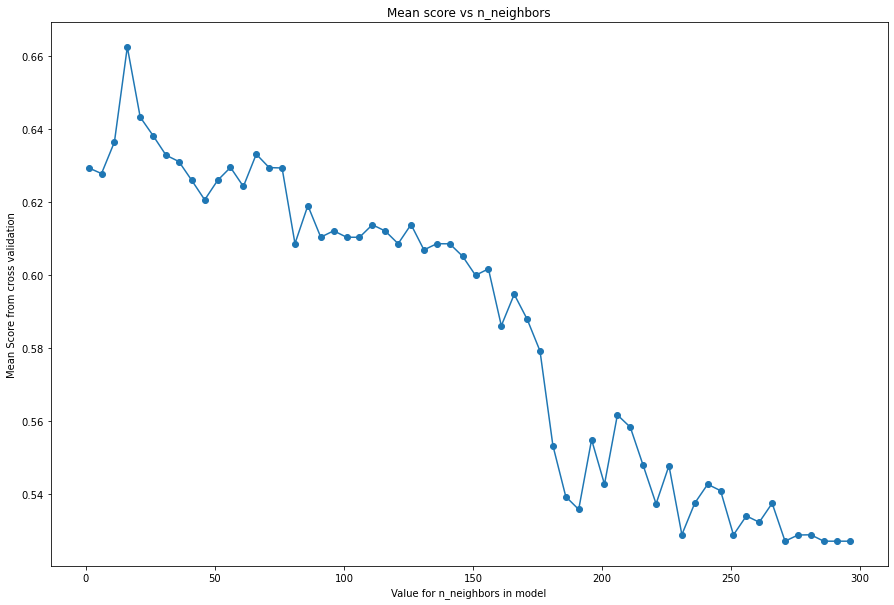

In [341]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier()
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

# Code to change default plot size:
plt.rcParams['figure.figsize'] = [15, 10]

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

From the graph it seems like the ideal number of neighbors is in the range between 10 and 50. We can do a grid search of all values in that range to better visualize the space.

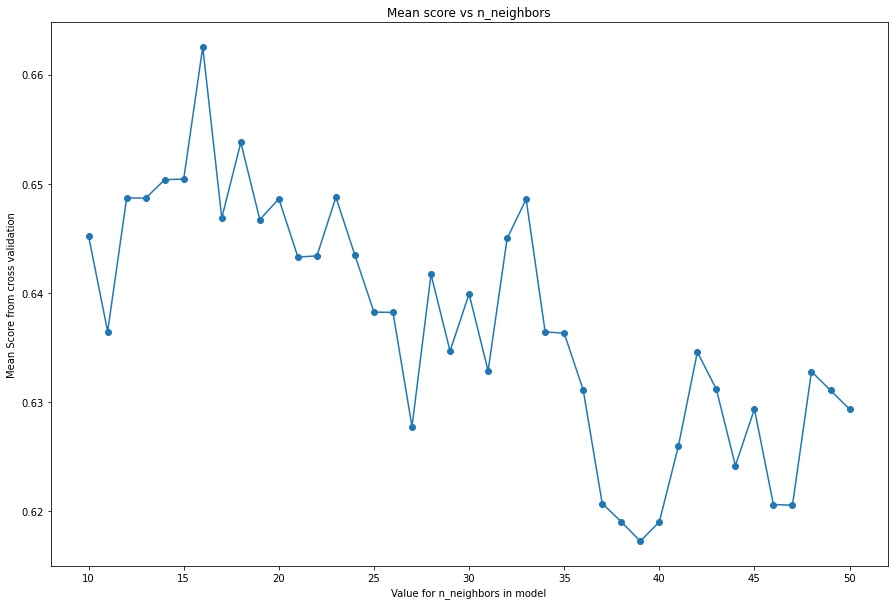

In [342]:
knn_model = KNeighborsClassifier()
test_k = range(10,50+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [343]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

16

There seems to be a peak in the data around $k=25$ so that will be the value for k we will use in the final model.

With these hyper parameters set, we can evaulate our model's performance on the test set.

In [344]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.5833333333333334

### K-nn - Predicting State

In [298]:
# Verifying we have enough data for each state

# state_count = {}
# for state in spending_member_info["STATE"].unique():
#     state_count[state] = sum(sum([spending_member_info["STATE"] == state]))
# state_count

We have a lot more data for states with more representitives

In [345]:
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_2_party[categories],spending_member_info_2_party["STATE"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


0.09059286146400483

We get an accurary score higher than 1/56 which looks promising.

We can now try to tune the hyperparameters. Starting with the way points in the k-nn model are weighted. Uniform weighting gives all k nearest points equal weighting, while the distance weighting weighs points by the inverse of their distance. The default weight in scikit learn is uniform so we are testing the distance weighting method.

In [346]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


0.09237749546279492

It looks like both weighting methods produce very similar accuracies. As a result, we will use the default that scikit learn uses as there is likely good reason it is the default and we do not have a good reason to change it.

Next we are going to look at the number of nearest neighbors and see how that changes our accuracy.

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


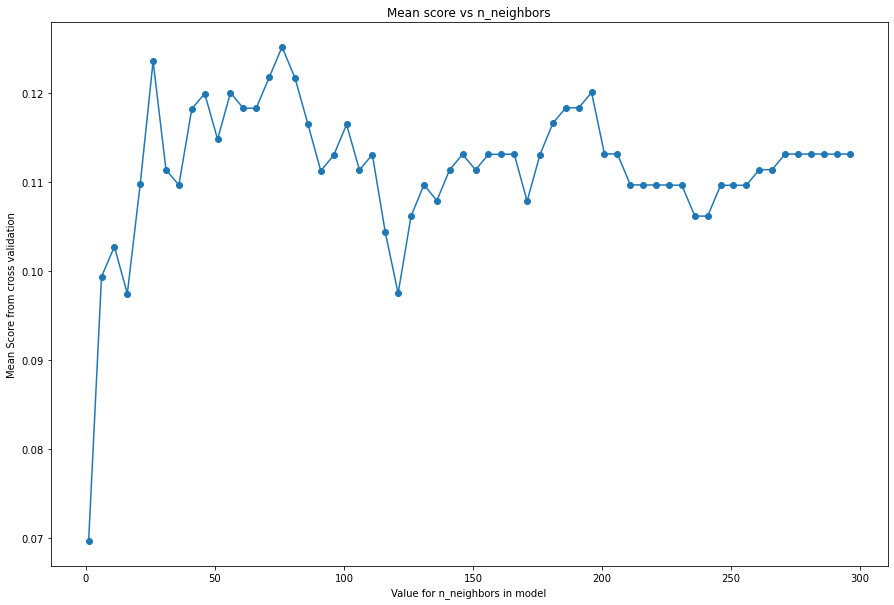

In [347]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier()
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

From the graph it seems like the ideal number of neighbors is in the range between 25 and 75. We can do a grid search of all values in that range to better visualize the space.

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


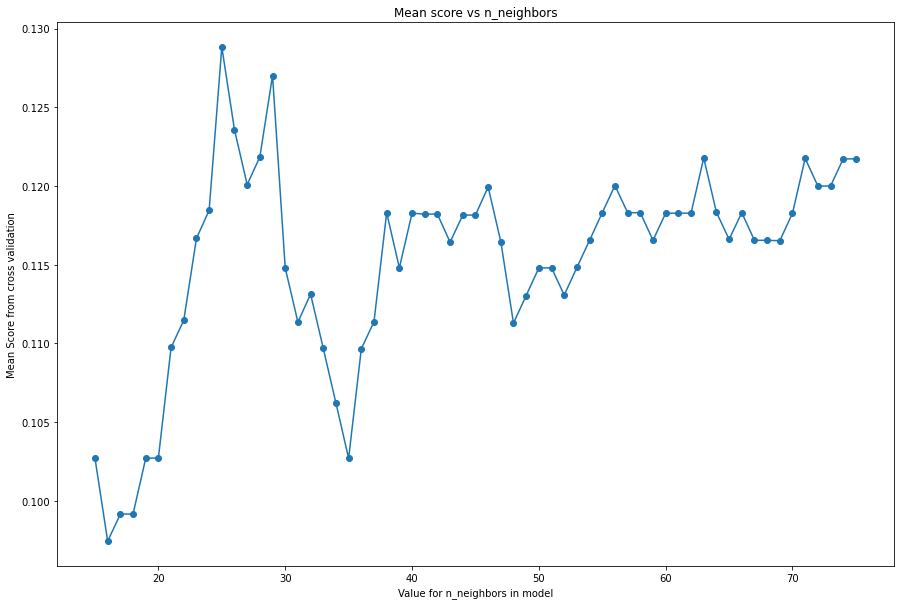

In [349]:
knn_model = KNeighborsClassifier()
test_k = range(15,75+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [350]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

25

There seems to be a peak in the data around $k = 52$ so that will be the value for k we will use in the final model.

With these hyper parameters set, we can evaulate our model's performance on the test set.

In [351]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.10416666666666667

This is a suprisingly high amount of accuracy. I believe this is actually a result of candidates having similar spending patterns over time, and since a canditate is likely to serve multiple terms for their state it makes sense that we can can predict state from spending patterns. To test this theory, I will see if we can predict a candidate based on their spending.

### K-nn - Candidate

In [305]:
bio_count = {}
for bio_id in spending_member_info["BIOGUIDE_ID"].unique():
    bio_count[bio_id] = sum(sum([spending_member_info["BIOGUIDE_ID"] == bio_id]))
bio_count

{'A000014': 5,
 'A000022': 15,
 'A000055': 31,
 'A000364': 6,
 'A000358': 13,
 'A000361': 18,
 'A000362': 14,
 'A000210': 21,
 'A000363': 6,
 'A000365': 16,
 'B001234': 14,
 'B001256': 24,
 'B000013': 25,
 'B001229': 7,
 'B001230': 14,
 'B001239': 6,
 'B001252': 22,
 'B000208': 14,
 'B000213': 31,
 'B001253': 9,
 'B000287': 31,
 'B001231': 16,
 'B000410': 16,
 'B000420': 8,
 'B001232': 12,
 'B000461': 15,
 'B001257': 31,
 'B001250': 31,
 'B000490': 31,
 'B001242': 23,
 'B001243': 31,
 'B000574': 31,
 'B000575': 5,
 'B001263': 9,
 'B000589': 25,
 'B001244': 20,
 'B001228': 15,
 'B001236': 8,
 'B001245': 31,
 'B001254': 15,
 'B000652': 16,
 'B000657': 7,
 'B001255': 28,
 'B000716': 5,
 'B000755': 31,
 'B001227': 31,
 'B001259': 22,
 'B001264': 6,
 'B001262': 22,
 'B001247': 6,
 'B000911': 29,
 'B001235': 5,
 'B001260': 31,
 'B001248': 31,
 'B001149': 16,
 'B001251': 31,
 'B001203': 7,
 'C000059': 31,
 'C000071': 23,
 'C001064': 21,
 'C001046': 24,
 'C001079': 7,
 'C001047': 23,
 'C001036

In [315]:
spending_member_info_candidates_arr = []
for bio_id in spending_member_info["BIOGUIDE_ID"].unique():
    count = sum(sum([spending_member_info["BIOGUIDE_ID"] == bio_id]))
    if count > 20:
        spending_member_info_candidates_arr.append(spending_member_info[spending_member_info["BIOGUIDE_ID"] == bio_id])
spending_member_info_candidates = pd.concat(spending_member_info_candidates_arr)
len(spending_member_info_candidates["BIOGUIDE_ID"].unique())

393

In [316]:
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_candidates[categories],spending_member_info_candidates["BIOGUIDE_ID"])
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.05519536209930721

In [317]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.06970314205520038

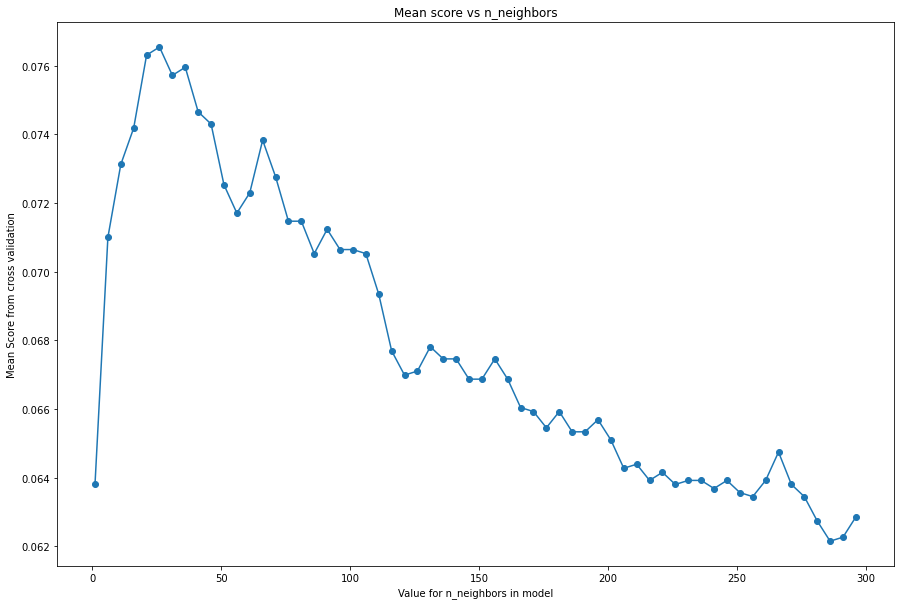

In [318]:
from sklearn.model_selection import GridSearchCV
knn_model = KNeighborsClassifier(weights='distance')
test_k = range(1,300+1,5)
params=[{
    'n_neighbors': test_k,
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()

fig, ax = plt.subplots()
ax.plot(test_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()

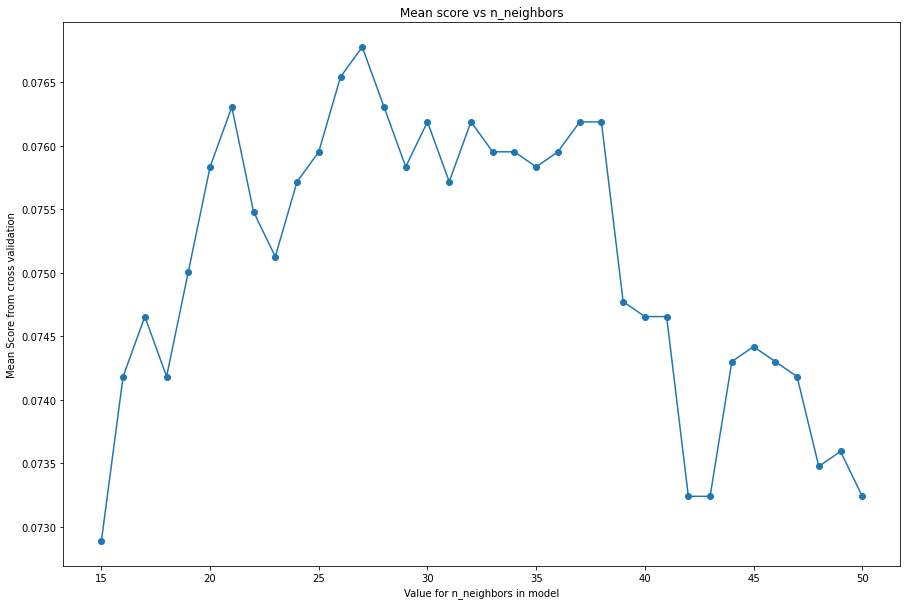

In [322]:
knn_model = KNeighborsClassifier(weights='distance')
test_k = range(15,50+1)
params=[{
    'n_neighbors': test_k,
    # 'weights': ['uniform', 'distance']
}]
gs_knn = GridSearchCV(knn_model, param_grid=params, cv=10, n_jobs=-1)
gs_knn.fit(x_train, y_train)
result_k = gs_knn.cv_results_['mean_test_score'].tolist()
tested_k = gs_knn.cv_results_['param_n_neighbors'].tolist()

fig, ax = plt.subplots()
ax.plot(tested_k, result_k, '-o')
ax.set_xlabel("Value for n_neighbors in model")
ax.set_ylabel("Mean Score from cross validation")
ax.set_title("Mean score vs n_neighbors")
fig.show()


In [323]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = tested_k[index_of_max]
optimal_k_val

27

In [326]:
knn_model = KNeighborsClassifier(weights='distance', n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.06579412805093739

Indicitive of clustering based on candidate expenditure

I should try to remake the first 2 models but with only 1 data point for each candidate